<a href="https://colab.research.google.com/github/hellojohnkim/mmai869/blob/main/2024_869_JohnKim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MMAI 869 2024: Individual Assignment

- Student Name: Kim, John
- Student Number: 20439250
- Section Number: MMAI 2024
- Favourite Book: Pachinko by Min Jin Lee
- Submitted Date: 2024-01-07

In [1]:
import datetime
import pandas as pd
import numpy as np

In [ ]:
print(datetime.datetime.now())

In [ ]:
!which python

In [ ]:
!python --version

In [ ]:
!echo $PYTHONPATH

# Question 1: Uncle Steve's Diamonds

## Instructions

You work at a local jewelry store named *Uncle Steve's Diamonds*. You started as a janitor, but you’ve recently been promoted to senior data analyst. Congratulations!

Uncle Steve, the store's owner, needs to better understand the store's customers. In particular, he wants to know what kind of customers shop at the store. He wants to know the main types of *customer personas*. Once he knows these, he will contemplate ways to better market to each persona, better satisfy each persona, better cater to each persona, increase the loyalty of each persona, etc. But first, he must know the personas.

You want to help Uncle Steve. Using sneaky magic (and the help of Environics), you've collected four useful features for a subset of the customers: age, income, spending score (i.e., a score based on how much they’ve spent at the store in total), and savings (i.e., how much money they have in their bank account).

**Your tasks**

1. Pick a clustering algorithm (the [`sklearn.cluster`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.cluster) module has many good choices, including [`KMeans`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans), [`DBSCAN`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html#sklearn.cluster.DBSCAN), and [`AgglomerativeClustering`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering) (aka Hierarchical)). (Note that another popular implementation of the hierarchical algorithm can be found in SciPy's [`scipy.cluster.hierarchy.linkage`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html).) Don't spend a lot of time thinking about which algorithm to choose - just pick one. Cluster the customers as best as you can, within reason. That is, try different feature preprocessing steps, hyperparameter values, and/or distance metrics. You don't need to try every posssible combination, but try a few at least. Measure how good each  model configuration is by calculating an internal validation metric (e.g., [`calinski_harabasz_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.calinski_harabasz_score.html) or [`silhouette_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html#sklearn.metrics.silhouette_score)).
2. You have some doubts - you're not sure if the algorithm you chose in part 1 is the best algorithm for this dataset/problem. Neither is Uncle Steve. So, choose a different algorithm (any!) and do it all again.
3. Which clustering algorithm is "better" in this case? Think about charateristics of the algorithm like quality of results, ease of use, speed, interpretability, etc. Choose a "winner" and justify to Uncle Steve.
4. Interpret the clusters of the winning model. That is, describe, in words, a *persona* that accurately depicts each cluster. Use statistics (e.g., cluster means/distributions), examples (e.g., exemplar instances from each cluster), and/or visualizations (e.g., relative importance plots, snakeplots) to get started. Human judgement and creativity will be necessary. This is where it all comes together. Be descriptive and *help Uncle Steve understand his customers better*. Please!

**Marking**

The coding parts (i.e., 1 and 2) will be marked based on:

- *Correctness*. Code clearly and fully performs the task specified.
- *Reproducibility*. Code is fully reproducible. I.e., you (and I) are able to run this Notebook again and again, from top to bottom, and get the same results each time.
- *Style*. Code is organized. All parts commented with clear reasoning and rationale. No old code laying around. Code easy to follow.


Parts 3 and 4 will be marked on:

- *Quality*. Response is well-justified and convincing. Responses uses facts and data where possible.
- *Style*. Response uses proper grammar, spelling, and punctuation. Response is clear and professional. Response is complete, but not overly-verbose. Response follows length guidelines.


**Tips**

- Since clustering is an unsupervised ML technique, you don't need to split the data into training/validation/test or anything like that. Phew!
- On the flip side, since clustering is unsupervised, you will never know the "true" clusters, and so you will never know if a given algorithm is "correct." There really is no notion of "correctness" - only "usefullness."
- Many online clustering tutorials (including some from Uncle Steve) create flashy visualizations of the clusters by plotting the instances on a 2-D graph and coloring each point by the cluster ID. This is really nice and all, but it can only work if your dataset only has exactly two features - no more, no less. This dataset has more than two features, so you cannot use this technique. (But that's OK - you don't need to use this technique.)
- Must you use all four features in the clustering? Not necessarily, no. But "throwing away" quality data, for no reason, is unlikely to improve a model.
- Some people have success applying a dimensionality reduction technique (like [`sklearn.decomposition.PCA`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)) to the features before clustering. You may do this if you wish, although it may not be as helpful in this case because there are only four features to begin with.
- If you apply a transformation (e.g., [`MinMaxScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) or [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler)) to the features before clustering, you may have difficulty interpretting the means of the clusters (e.g., what is a mean Age of 0.2234??). There are two options to fix this: first, you can always reverse a transformation with the `inverse_transform` method. Second, you can just use the original dataset (i.e., before any preprocessing) during the interpreation step.
- You cannot change the distance metric for K-Means. (This is for theoretical reasons: K-Means only works/makes sense with Euclidean distance.)


## 1.0: Load data

In [2]:
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture

In [3]:
# DO NOT MODIFY THIS CELL
df1 = pd.read_csv("https://drive.google.com/uc?export=download&id=1thHDCwQK3GijytoSSZNekAsItN_FGHtm")
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Age            505 non-null    int64  
 1   Income         505 non-null    int64  
 2   SpendingScore  505 non-null    float64
 3   Savings        505 non-null    float64
dtypes: float64(2), int64(2)
memory usage: 15.9 KB


In [4]:
df1.head(100)

,Age,Income,SpendingScore,Savings
0,58,77769,0.791329,6559.829923
1,59,81799,0.791082,5417.661426
2,62,74751,0.702657,9258.992965
3,59,74373,0.765680,7346.334504
4,87,17760,0.348778,16869.507130
...,...,...,...,...
95,25,130934,0.913766,3942.389134
96,36,101811,0.340667,15048.899612
97,62,73480,0.739195,6277.675151
98,66,72571,0.811548,6509.411506


In [9]:
df1.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
Age,505.0,59.019802,24.140043,17.0,34.000000,59.000000,85.000000,97.0
Income,505.0,75513.291089,35992.922184,12000.0,34529.000000,75078.000000,107100.000000,142000.0
SpendingScore,505.0,0.505083,0.259634,0.0,0.304792,0.368215,0.768279,1.0
Savings,505.0,11862.455867,4949.229253,0.0,6828.709702,14209.932802,16047.268331,20000.0


In [10]:
## Data Exploration
df1.describe()
list(df1)
df1.shape
df1.info()
df1.head(n=20)
df1.describe().transpose()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Age            505 non-null    int64  
 1   Income         505 non-null    int64  
 2   SpendingScore  505 non-null    float64
 3   Savings        505 non-null    float64
dtypes: float64(2), int64(2)
memory usage: 15.9 KB


,count,mean,std,min,25%,50%,75%,max
Age,505.0,59.019802,24.140043,17.0,34.000000,59.000000,85.000000,97.0
Income,505.0,75513.291089,35992.922184,12000.0,34529.000000,75078.000000,107100.000000,142000.0
SpendingScore,505.0,0.505083,0.259634,0.0,0.304792,0.368215,0.768279,1.0
Savings,505.0,11862.455867,4949.229253,0.0,6828.709702,14209.932802,16047.268331,20000.0


In [11]:
col_names = df1.columns

X = df1.to_numpy()

In [13]:
X.shape

(505, 4)

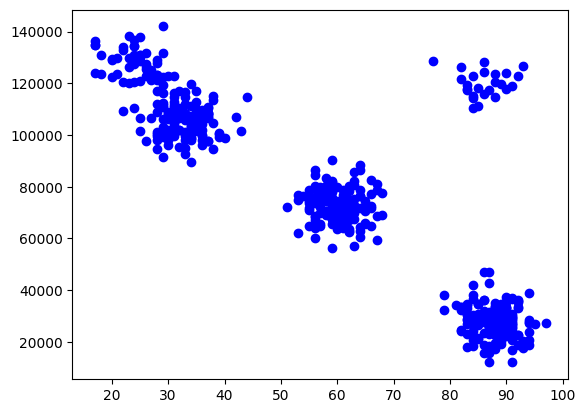

In [14]:
plt.figure()
plt.scatter(X[:,0],X[:,1], c='blue')

## 1.1: Clustering Algorithm #1

In [15]:
from sklearn.preprocessing import StandardScaler

# Pre-processing steps before clustering 
# use standard scaler to standardize the values in the data before we apply clsutering
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [16]:
from sklearn.cluster import KMeans

k_means = KMeans(init="k-means++", n_clusters = 4, n_init=10, random_state=42)
k_means.fit(X)

KMeans(n_clusters=4, n_init=10, random_state=42)

In [17]:
# Get the cluster labels for each data point
labels = k_means.labels_
labels

array([0, 0, 0, 0, 1, 3, 0, 1, 1, 1, 2, 2, 2, 2, 0, 2, 0, 1, 1, 2, 2, 2,
       0, 1, 2, 3, 3, 0, 1, 0, 0, 0, 1, 0, 2, 0, 1, 0, 2, 2, 0, 1, 3, 0,
       0, 3, 2, 3, 2, 0, 1, 2, 3, 1, 0, 1, 2, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 3, 3, 0, 0, 2, 1, 1, 2, 0, 2, 0, 0, 3, 0, 2, 0, 1, 1, 2, 2, 0,
       0, 0, 0, 0, 3, 1, 0, 3, 2, 0, 0, 2, 2, 3, 2, 3, 2, 1, 1, 2, 2, 0,
       1, 2, 0, 2, 2, 2, 0, 2, 3, 1, 2, 1, 1, 1, 2, 2, 0, 1, 0, 0, 2, 0,
       2, 0, 3, 1, 2, 3, 0, 2, 1, 0, 0, 3, 0, 3, 0, 2, 0, 1, 0, 2, 1, 0,
       1, 2, 2, 0, 1, 0, 2, 1, 0, 2, 1, 2, 1, 0, 2, 0, 1, 0, 2, 0, 1, 0,
       0, 1, 1, 1, 0, 0, 2, 3, 3, 1, 2, 0, 0, 0, 2, 1, 0, 0, 0, 1, 3, 2,
       1, 1, 1, 2, 0, 2, 0, 2, 0, 1, 3, 0, 1, 1, 1, 1, 0, 1, 2, 3, 2, 1,
       0, 0, 2, 1, 2, 3, 2, 0, 0, 1, 0, 0, 1, 0, 0, 0, 2, 0, 2, 2, 3, 0,
       0, 0, 2, 0, 2, 1, 3, 3, 3, 1, 0, 2, 1, 1, 2, 2, 0, 0, 2, 0, 0, 1,
       0, 1, 2, 3, 0, 2, 1, 0, 1, 1, 2, 0, 1, 1, 0, 0, 1, 2, 2, 2, 2, 1,
       1, 2, 2, 1, 1, 3, 0, 2, 2, 0, 2, 1, 1, 2, 0,

In [18]:
#centroids values
k_means.cluster_centers_

array([[ 0.03879611, -0.08524639,  1.02721559, -1.00569483],
       [ 1.19238486, -1.32510593, -0.67963841,  0.97016358],
       [-0.72276928,  0.89502598, -0.90658925,  0.62188649],
       [-1.44466803,  1.46050665,  1.51057952, -1.57249636]])

In [19]:
scaler.inverse_transform(k_means.cluster_centers_)

array([[5.99554140e+01, 7.24480637e+04, 7.71518368e-01, 6.88997219e+03],
       [8.77755102e+01, 2.78661020e+04, 3.28800461e-01, 1.66592614e+04],
       [4.15894040e+01, 1.07695980e+05, 2.69934734e-01, 1.49372658e+04],
       [2.41800000e+01, 1.28029120e+05, 8.96891640e-01, 4.08752031e+03]])

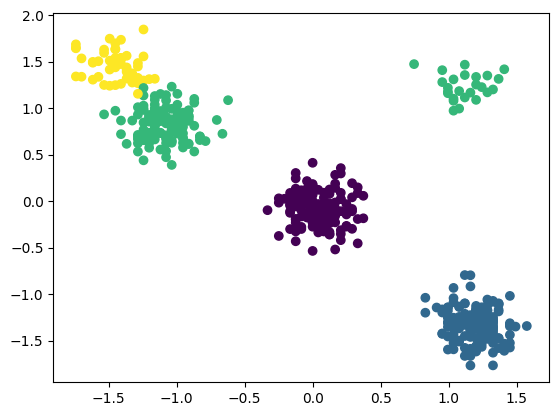

In [20]:
# Plot the data points with different colors for each cluster
plt.scatter(X[:, 0], X[:, 1], c=labels)
plt.show()


In [ ]:
# Calculate the silhouette score for the KMeans model
silhouette_score(X, labels)

# Calculate the silhouette samples for the KMeans model
silhouette_samples(X, labels)

## 1.2: Clustering Algorithm #2

In [21]:
from scipy.cluster.hierarchy import linkage

#call the linkage function
aggl = linkage(X, method='ward', metric='euclidean')

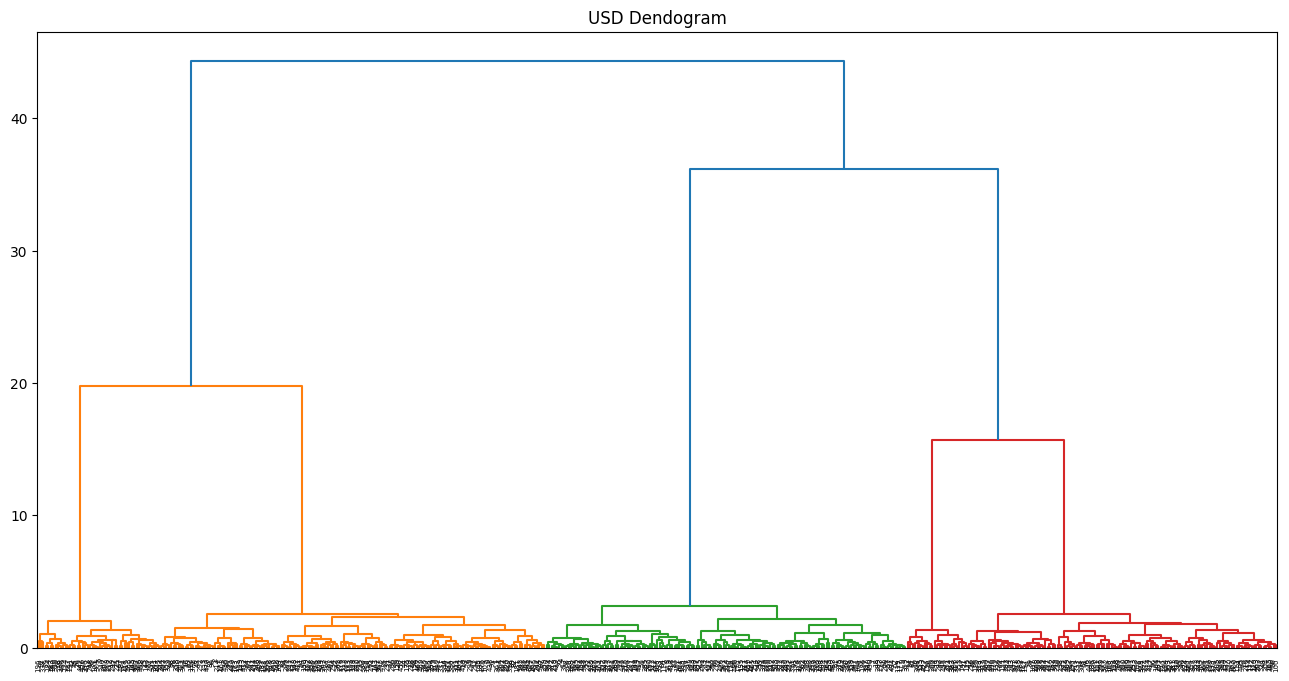

In [23]:
import scipy
from scipy.cluster.hierarchy import dendrogram

# Plot the dendogram 0 this time with better labels
plt.figure(figsize=(16, 8));
plt.grid(False)
plt.title("USD Dendogram");  
dend = scipy.cluster.hierarchy.dendrogram(aggl); 

In [25]:
# Let's find K=5 clusters
K=5
labels = scipy.cluster.hierarchy.fcluster(aggl, K, criterion="maxclust")

In [26]:
df1['Cluster ID'] = labels
df1.head(9)

,Age,Income,SpendingScore,Savings,Cluster ID
0,58,77769,0.791329,6559.829923,2
1,59,81799,0.791082,5417.661426,2
2,62,74751,0.702657,9258.992965,2
3,59,74373,0.765680,7346.334504,2
4,87,17760,0.348778,16869.507130,3
5,29,131578,0.847034,3535.514352,1
6,54,76500,0.785198,6878.884249,2
7,87,42592,0.355290,18086.287158,3
8,83,34384,0.324719,14783.379086,3


In [27]:
import pandas as pd

X_df = pd.DataFrame(scaler.inverse_transform(df1), columns=df1.columns)
X_df['Cluster'] = labels
X_df.head()

cl_group = X_df.groupby(['Cluster']).agg('describe')
cl_group

cl_group.info()
cl_group['Age']

ValueError: operands could not be broadcast together with shapes (505,5) (4,) (505,5) 

## 1.3 Model Comparison

## 1.4 Personas

TODO: Delete this text and insert your answer here.

# Question 2: Uncle Steve's Fine Foods

## 2.1: A rule that might have high support and high confidence.

Rule: {frozen pizza} -> {beer}
Answer: This rule would have high support and confidence as both are popular for casual dining and social gatherings. Uncle Steve might find this rule somewhat obvious, as the combination is a common choice for quick meals and parties.

Rule: {organic vegetables} -> {plant-based milk}
Answer: This rule would likely have high support and confidence, reflecting a health-conscious consumer trend. However, Uncle Steve might not find it very surprising, given the increasing popularity of organic and plant-based products.

Rule: {baby food} -> {baby wipes}
Answer: This rule would have high support and confidence due to the necessities for parents with infants. Uncle Steve might already be aware of this pattern, as these are essential items for a specific customer segment.

Rule: {sports drinks} -> {protein bars}
Answer: The rule would likely have high support and confidence, catering to fitness enthusiasts. This might not be novel to Uncle Steve, as the pairing is a well-known trend among health-conscious customers.

Rule: {instant coffee} -> {breakfast biscuits}
Answer: This rule would have high support and confidence as a common quick breakfast choice. However, this may not be particularly insightful for Uncle Steve, as the pairing is typical for busy, on-the-go lifestyles.

## 2.2: A rule that might have reasonably high support but low confidence.

Rule: {wine} -> {gourmet cheese}
Answer: This rule would have reasonably high support but low confidence, common in social settings but not always purchased together. Uncle Steve might find this interesting for targeted promotions, although the pairing is fairly well-known.

Rule: {sunscreen} -> {beach toys}
Answer: This rule would have high support but low confidence due to their seasonal nature. This might not be a revelation to Uncle Steve, but it could suggest strategic placement during summer months.

Rule: {fresh herbs} -> {exotic spices}
Answer: This rule might have high support but low confidence, reflecting a segment interested in gourmet cooking. Uncle Steve might find this pairing obvious, yet it could inform targeted marketing strategies.

Rule: {artisan bread} -> {olive oil}
Answer: This rule would have high support but low confidence, common for premium dining experiences. Uncle Steve might not find this particularly surprising, as it's a well-known combination among food enthusiasts.

Rule: {energy drinks} -> {gaming accessories}
Answer: This rule would have high support but low confidence, appealing to a younger demographic. While not novel to Uncle Steve, it could inform targeted marketing efforts for this specific customer group.

## 2.3: A rule that might have low support and low confidence.

Rule: {gluten-free pasta} -> {soy candles}
Answer: This rule would have low support and confidence, reflecting a niche wellness-focused lifestyle. Uncle Steve might find this combination too obscure and not particularly actionable for store strategy.

Rule: {gourmet dog food} -> {craft beer}
Answer: This rule would have low support and low confidence, indicating a demographic of upscale pet owners. While creative, Uncle Steve might consider this pairing too unconventional for practical marketing use.

Rule: {travel magazines} -> {international foods}
Answer: This rule would have low support and confidence, appealing to a globally-minded customer. Uncle Steve might find this interesting but too niche for widespread application in his store.

Rule: {eco-friendly cleaning products} -> {reusable bags}
Answer: This rule would have low support and confidence, suggesting environmentally conscious customers. Uncle Steve might consider this too specific, although it aligns with sustainable living trends.

Rule: {yoga mats} -> {kombucha}
Answer: This rule would have low support and confidence, reflecting a health and wellness lifestyle. While interesting, Uncle Steve might find it too niche for general store strategy.

## 2.4: A rule that might have low support and high confidence.

Rule: {champagne} -> {luxury chocolates}
Answer: This rule would have low support but high confidence, specific to celebrations or gifts. Uncle Steve might find this pairing insightful for special occasions, although it's a relatively niche market.

Rule: {gourmet coffee beans} -> {French press}
Answer: This rule would have low support but high confidence, appealing to coffee connoisseurs. Uncle Steve might consider this too specific for the general customer base, but useful for targeting a premium segment.

Rule: {allergy medicine} -> {air purifiers}
Answer: This rule would have low support but high confidence, targeted to customers with health concerns. While specific, Uncle Steve might find it useful for a 'health and wellness' focused display.

Rule: {camping gear} -> {trail mix}
Answer: This rule would have low support but high confidence, reflecting outdoor enthusiasts. Uncle Steve might see this as too seasonal and niche, but it could inform summer product placements.

Rule: {vegan snacks} -> {eco-friendly personal care products}
Answer: This rule would have low support but high confidence, indicating a lifestyle-focused consumer group. Uncle Steve might find this too targeted for his general customer base, but it aligns with sustainable living trends.

# Question 3: Uncle Steve's Credit Union

## 3.0: Load data and split

In [ ]:
# DO NOT MODIFY THIS CELL

# First, we'll read the provided labeled training data
df3 = pd.read_csv("https://drive.google.com/uc?export=download&id=1wOhyCnvGeY4jplxI8lZ-bbYN3zLtickf")
df3.info()

from sklearn.model_selection import train_test_split

X = df3.drop('BadCredit', axis=1) #.select_dtypes(['number'])
y = df3['BadCredit']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X.head()
X_train.shape, X_test.shape, y_train.shape, y_test.shape
X_train.select_dtypes(include=['object']).columns

## 3.1: Baseline model



In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder

# Identifying categorical columns
categorical_cols = X_train.select_dtypes(include=['object']).columns

# Creating a column transformer for one-hot encoding categorical variables
preprocessor = ColumnTransformer(transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)], remainder='passthrough')

# Creating a pipeline with preprocessor and a Random Forestclassifier
pipeline = Pipeline(steps=[('preprocessor', preprocessor),('classifier', RandomForestClassifier(random_state=42))])

# Performing 10-fold cross-validation to evaluate the baseline model
scores = cross_val_score(pipeline, X_train, y_train, cv=10, scoring='roc_auc')

# Displaying the mean score
print("Mean ROC AUC Score:", scores.mean())


## 3.2: Adding feature engineering

## 3.3: Adding feature selection

## 3.4: Adding hyperparameter tuning

## 3.5: Performance estimation on testing data

# Question 4: Uncle Steve's Wind Farm

# Answers
**Current Situtation**
- 256 Failed Turbines
- Failure Repair Cost: $20,000 per turbine
- Mainteance Service Cost: $2,000 per turbine
- Inspection CostL $500 per turbine

Uncle Steve is currently paying $5.12 million in maintenance costs without any predictive mainteance models,

- number of fails * failure repair cost per turbine = 256 turbines * $20,000 = $5,120,000

Random Forest Model will save $3,492,500 for Uncle Steve and cost less than RNN Model.

Additional metrics like

|         | Cost           |Savings   |
| ------------- |:------------:|:------------:
| **No Predictive Models**      | $5,120,000 |  -    |
| **Random Forest**   | **$1,627,500** | **$3,492,500** |
| **Recurrent Neural Network**   | $1,765,000 | $3,355,000 |


**Random Forest Cost Analysis**

Confusion matrix for the random forest:
|         | Predicted Fail           | Predicted No Fail  | |
| ------------- |:------------:| :-----:|:-----:|
| **Actual Fail**      | 201 | 55 |256|
| **Actual No Fail**   | 50 | 255,195 |255,245|
|                      | 251|255,250|255,501|

Cost matrix for the random forest:
|         | Predicted Fail           | Predicted No Fail  |
| ------------- |:------------:| :-----:|
| **Actual Fail**      | $2500 | $20,000 |
| **Actual No Fail**   | $500 | - |

Total Cost for the random forest:
|         | Predicted Fail           | Predicted No Fail  |
| ------------- |:------------:| :-----:|
| **Actual Fail**      | $502,500 | $1,100,000 |
| **Actual No Fail**   | $25,000 | - |

Total Cost = $502,500 + $25,000 + $1,100,000 =  $1,627,500

**RNN Cost Analysis**

Confusion matrix for the RNN:
|         | Predicted Fail           | Predicted No Fail  | |
| ------------- |:------------:| :-----:|:-----:|
| **Actual Fail**      | 226 | 30 |256|
| **Actual No Fail**   | 1200 | 25,4045 | 254,245|
|                      | 1426 | 254,075| 255,501|

Cost matrix for the RNN:
|         | Predicted Fail           | Predicted No Fail  |
| ------------- |:------------:| :-----:|
| **Actual Fail**      | $2500 | $20,000 |
| **Actual No Fail**   | $500 | - |

Total Cost for the RNN:
|         | Predicted Fail           | Predicted No Fail  |
| ------------- |:------------:| :-----:|
| **Actual Fail**      |  $565,000  | $600,000  |
| **Actual No Fail**   |  $600,000  | - |

Total Cost = $565,000 + $600,000 + $600,000 = $1,765,000